In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd

import torch
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pacmap

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.cm as cm
import pickle as pkl
import matplotlib.pyplot as plt
# Single methods
from sklearn.preprocessing import MinMaxScaler as Normalizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
from sklearn.metrics import silhouette_samples
from Modules.Clustering_Utils_Zamuro import plot_silhouette
from Modules.Clustering_Utils_Zamuro import plot_centroids
from Modules.Clustering_Utils_Zamuro import ClusteringResults
from sklearn.metrics import davies_bouldin_score as DB
from sklearn.metrics import calinski_harabasz_score as CH
import folium
from folium.plugins import HeatMap

from torch.utils.data import DataLoader
from torch.utils.data import random_split
from Zamuro_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

In [3]:
root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
model_type = "AE"
identifier = "batch_size_14_num_hiddens_64_"
day = 4
hour = 9
date_format = f"day_{day}_hour_{hour}"
model_name = f"{root}/Zamuro/temporal_zamuro/models/log_standarization_model_epochs_10/model_{model_type}_{identifier}_{date_format}_final.pth"
model = AE(num_hiddens=64).to(device)
model.load_state_dict(torch.load(f'{model_name}', map_location=torch.device('cpu')))

filters = {"rain_FI": "NO"}
dataset = SoundscapeData('media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/',
                         dataframe_path="Complementary_Files/zamuro_audios.csv",
                         audio_length=12, ext="wav",
                         win_length=1028, filters=filters)

test_loader = DataLoader(dataset, batch_size=100)
iterator = iter(test_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))

/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/


In [4]:
audios = pd.read_csv(f"Complementary_Files/zamuro_audios_complete.csv", index_col=0)
recorders = pd.read_csv(f"Complementary_Files/zamuro_recorders_satelites.csv", index_col=0)
# Filtrar el DataFrame eliminando las filas donde field_number_PR sea igual a 'RZUD06'
recorders = recorders[recorders['field_number_PR'] != 'RZUD06']
audios = audios[audios['field_number_PR'] != 'RZUD06']

In [5]:
df_ae = pd.read_csv(f"temporal_zamuro/Features/New_df_ae_unflat.csv")
df_ae.set_index("y", inplace=True)
df_ae = df_ae[df_ae['location'] != 'RZUD06']
X = np.asarray(df_ae.loc[:,"0":"25919"])
X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
X = np.mean(X, axis=1)

In [6]:
root_ai_Zamuro = f"temporal_zamuro/Features/New_df_ai.csv"
df_ai = pd.read_csv(root_ai_Zamuro, index_col=0)
df_ai = df_ai[df_ai['location'] != 'RZUD06']
AIs = np.asarray(df_ai.iloc[:,2:-6])

# K-Means and UMAP

In [7]:
mapper = umap.UMAP(n_components=2, min_dist=0.01,
                            metric="euclidean", n_neighbors=75,
                            random_state=0, n_jobs=-1).fit(X)
X_UMAP = mapper.transform(X)

In [8]:
X_UMAP.shape

(52603, 2)

In [9]:
X_UMAP_df = pd.DataFrame(X_UMAP, columns=['UMAP1', 'UMAP2'])

df_UMAP = df_ae.copy()

X_UMAP_df.index = df_UMAP.index

cols_to_replace = [str(i) for i in range(25920)]  # Nombres de columnas como strings

existing_cols = [col for col in cols_to_replace if col in df_UMAP.columns]

df_UMAP = df_UMAP.drop(columns=existing_cols)

df_UMAP = pd.concat([df_UMAP, X_UMAP_df], axis=1)


In [10]:
Clustering = KMeans(n_clusters=9, random_state=0).fit(X_UMAP)
Results = ClusteringResults(Clustering, df_UMAP, y_label="hour")
df_new = Results.tagger()
# df_new.set_index("y", inplace=True, drop=False)
df_new.rename_axis('Filename_', inplace=True)

audios_filtered = audios[audios.index.isin(df_new.index)]
audios_final = audios_filtered.join(df_new['cluster'], how='left')


conteo_clusters = audios_final.groupby(['location', 'cluster']).size().unstack(fill_value=0)
conteo_clusters.columns = [f'cluster_{col}' for col in conteo_clusters.columns]
recorders_clusters = recorders.join(conteo_clusters, on='field_number_PR')

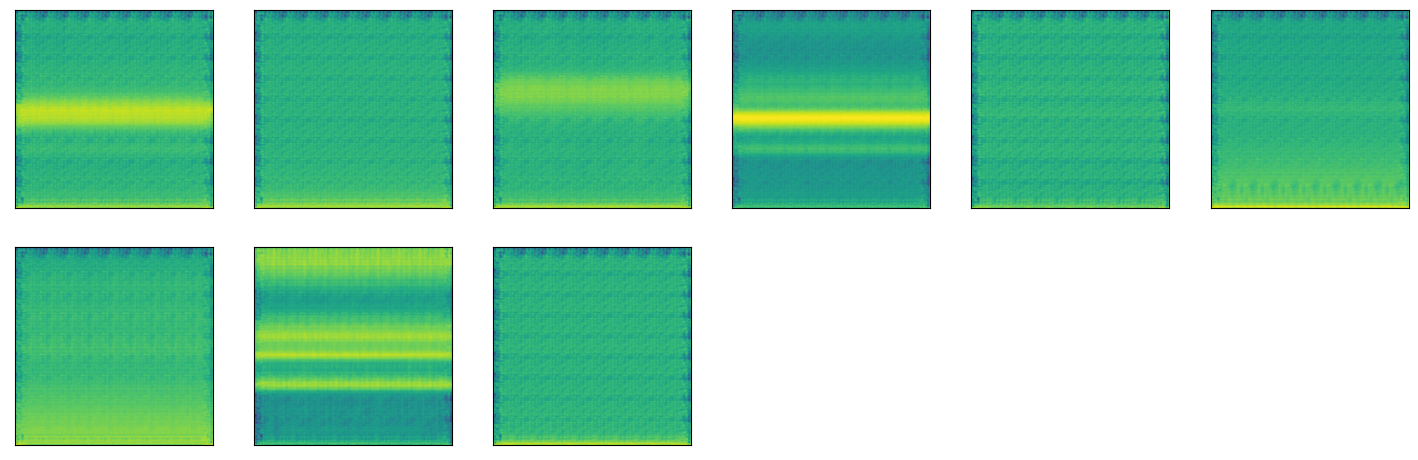

Ploted!


In [11]:
%matplotlib inline
cluster_centers = Clustering.cluster_centers_ #Normalizer_.inverse_transform(Kmeans.cluster_centers_)
cluster_centers_inverse = mapper.inverse_transform(cluster_centers)
plot_centroids(cluster_centers_inverse, testing,) # save=True, #cluster_centers_inverse for UMAP, root=f"temporal_zamuro/zamuro_clustering_results/Kmeans_Normal/")

In [12]:
grabadora = "RZUH12"  # Cambia esto al nombre de la grabadora que quieres verificar

audios_grabadora = audios_final[audios_final['location'] == grabadora]

conteo_por_cluster = audios_grabadora['cluster'].value_counts()

print(conteo_por_cluster)

conteo_clusters = audios_final['cluster'].value_counts()

print(conteo_clusters)

cluster
7    276
2    114
1     83
0     63
5     55
3     26
6     13
8      1
Name: count, dtype: int64
cluster
7    9564
2    8950
0    8257
3    8181
1    6539
6    5776
5    4553
4     433
8     350
Name: count, dtype: int64


In [13]:
%matplotlib qt
mapa = folium.Map(location=[3.515, -73.411489], zoom_start=13.2)

puntos = recorders_clusters[['latitude_IG', 'longitud_IG', 'cluster_0']].values.tolist()
valores = recorders_clusters["cluster_1"].tolist()
HeatMap(puntos, radius=18, ).add_to(mapa)
mapa

In [14]:
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from scipy.interpolate import griddata

In [15]:
geometry = [Point(xy) for xy in zip(recorders_clusters['longitud_IG'], recorders_clusters['latitude_IG'])]
gdf = gpd.GeoDataFrame(recorders_clusters, geometry=geometry)

# Cargar el archivo TIF para obtener los límites del mapa
tif_path = 'Complementary_Files/COB.tif'

with rasterio.open(tif_path) as tif:
    bounds = tif.bounds

In [16]:
with rasterio.open(tif_path) as src:
    # Read the raster data
    tiff_data = src.read(1)  # Assuming it's a single-band GeoTIFF

    # Get the extent of the GeoTIFF
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(10, 10))

    # Display the GeoTIFF data as an image
    im = ax.imshow(tiff_data, cmap='gray', extent=extent, origin='upper')

    # Plot the points from the CSV file on top of the GeoTIFF
    gdf.plot(ax=ax, column='cluster_3', cmap='Pastel1', markersize=10, legend=True)

    # Add a colorbar
    plt.colorbar(im, ax=ax, label='component3_prob')

    # Set the title
    ax.set_title('Cluster 3 with Points from CSV and GeoTIFF')

    # Show the plot
    plt.show()


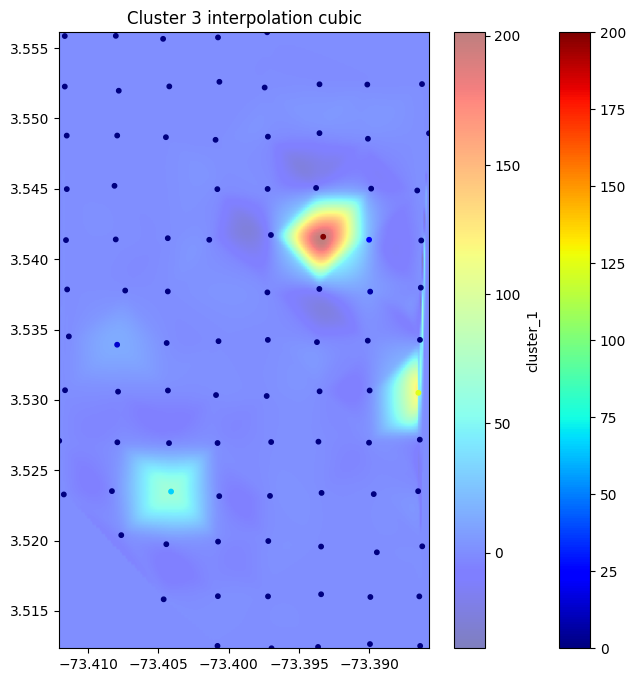

In [17]:
%matplotlib inline
resolution = 200

# Crea una cuadrícula regular para la interpolación
x_min, x_max = recorders_clusters['longitud_IG'].min(), recorders_clusters['longitud_IG'].max()
y_min, y_max = recorders_clusters['latitude_IG'].min(), recorders_clusters['latitude_IG'].max()
x_grid = np.linspace(x_min, x_max, resolution)
y_grid = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x_grid, y_grid)

# Realiza la interpolación utilizando griddata
Z3 = griddata((recorders_clusters['longitud_IG'], recorders_clusters['latitude_IG']), recorders_clusters['cluster_4'], (X, Y), method='cubic',fill_value=0)

fig, ax = plt.subplots(figsize=(8, 8))

# Visualiza los puntos originales
gdf.plot(ax=ax, column='cluster_4', cmap='jet', markersize=10, legend=True)

# Visualiza la interpolación como un mapa de calor
im = ax.imshow(Z3, origin='lower', extent=[x_min, x_max, y_min, y_max], cmap='jet', alpha=0.5)
plt.colorbar(im, ax=ax, label='cluster_1')
limited_dataimg = im.get_array()

ax.set_title('Cluster 3 interpolation cubic')
plt.show()


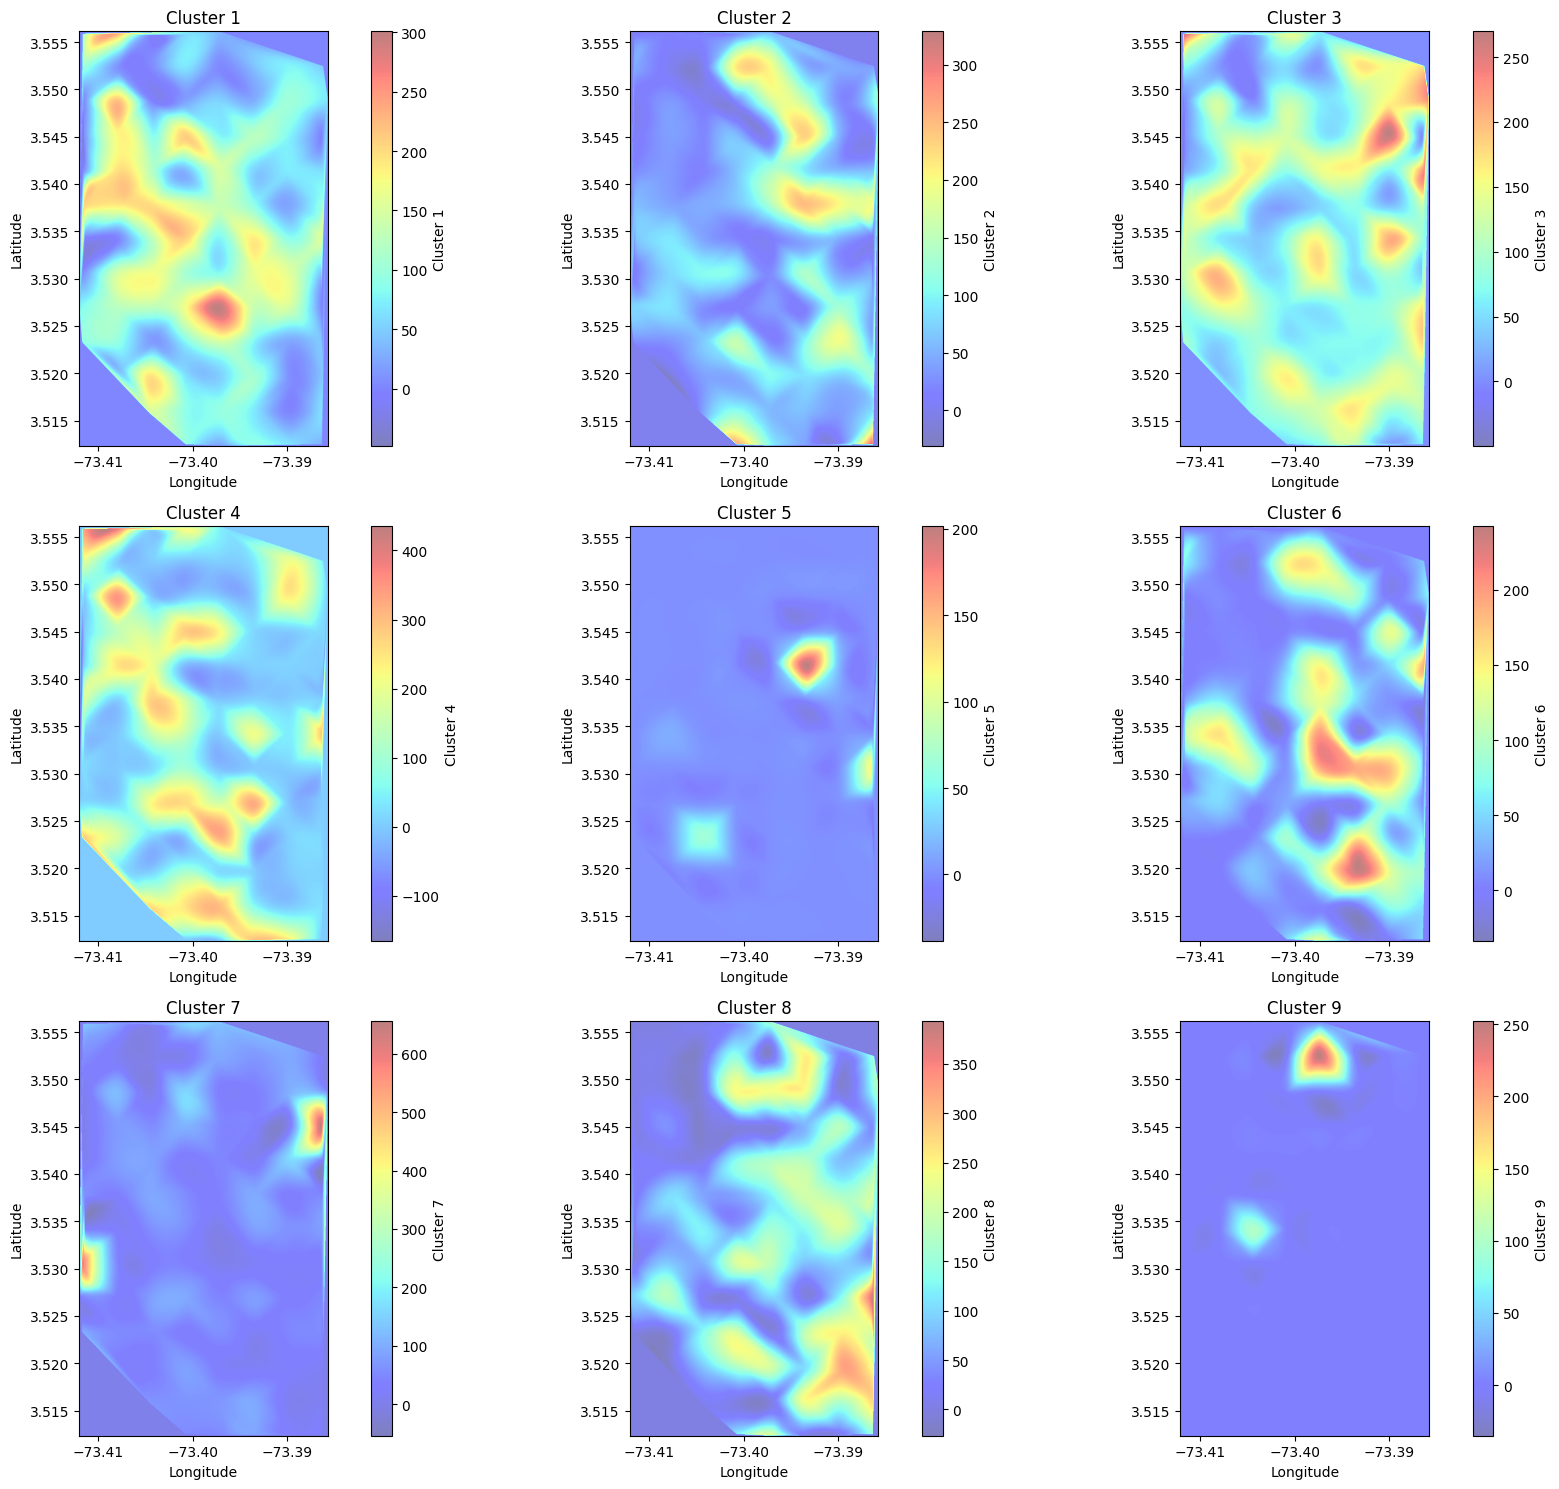

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geopandas as gpd

%matplotlib inline
resolution = 1000

# Crea una cuadrícula regular para la interpolación
x_min, x_max = recorders_clusters['longitud_IG'].min(), recorders_clusters['longitud_IG'].max()
y_min, y_max = recorders_clusters['latitude_IG'].min(), recorders_clusters['latitude_IG'].max()
x_grid = np.linspace(x_min, x_max, resolution)
y_grid = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x_grid, y_grid)

# Crear los subgráficos
fig, axes = plt.subplots(3, 3, figsize=(20, 15))  # 3 filas y 4 columnas para acomodar 10 clusters
axes = axes.flatten()  # Hacer que sea más fácil acceder a cada subplot

# Iterar sobre los clusters y realizar la interpolación
for i in range(9):
    Z = griddata((recorders_clusters['longitud_IG'], recorders_clusters['latitude_IG']),
                 recorders_clusters[f'cluster_{i}'], (X, Y), method='cubic', fill_value=0)

    # Graficar el mapa de calor para cada cluster
    ax = axes[i]
    im = ax.imshow(Z, origin='lower', extent=[x_min, x_max, y_min, y_max], cmap='jet', alpha=0.5)
    ax.set_title(f'Cluster {i+1}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    fig.colorbar(im, ax=ax, label=f'Cluster {i+1}')
    plt.tight_layout()

# Ajustar el diseño
plt.tight_layout()
plt.show()

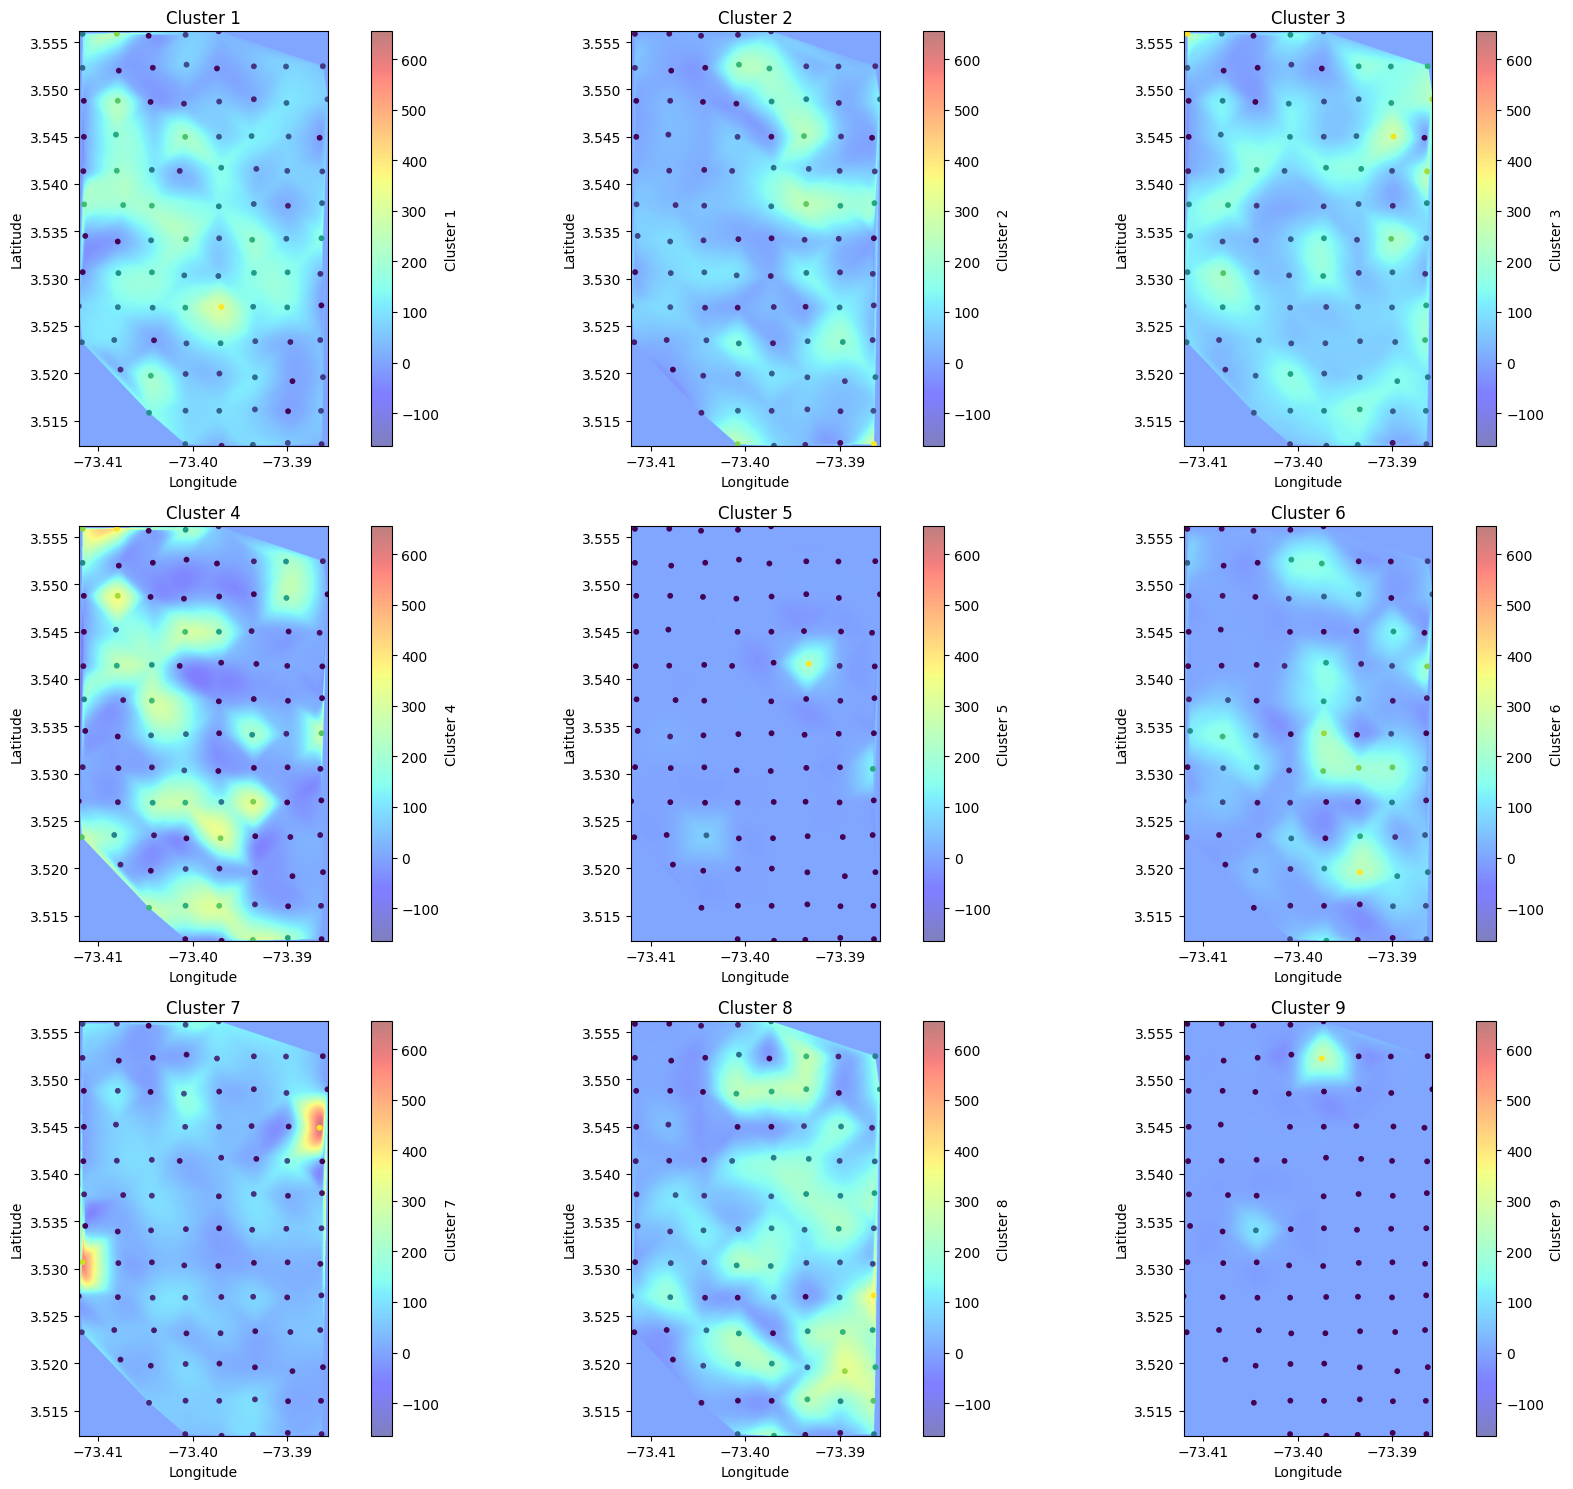

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geopandas as gpd

%matplotlib inline
resolution = 1000

# Crea una cuadrícula regular para la interpolación
x_min, x_max = recorders_clusters['longitud_IG'].min(), recorders_clusters['longitud_IG'].max()
y_min, y_max = recorders_clusters['latitude_IG'].min(), recorders_clusters['latitude_IG'].max()
x_grid = np.linspace(x_min, x_max, resolution)
y_grid = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x_grid, y_grid)

# Calcular el rango común de valores para todas las interpolaciones
z_min, z_max = float('inf'), float('-inf')
for i in range( 8):  # Iterar sobre los clusters
    Z = griddata((recorders_clusters['longitud_IG'], recorders_clusters['latitude_IG']),
                 recorders_clusters[f'cluster_{i}'], (X, Y), method='cubic', fill_value=0)
    z_min = min(z_min, Z.min())
    z_max = max(z_max, Z.max())

# Crear los subgráficos
fig, axes = plt.subplots(3, 3, figsize=(20, 15))  # 3 filas y 3 columnas para acomodar 9 gráficos
axes = axes.flatten()  # Hacer que sea más fácil acceder a cada subplot

# Iterar sobre los clusters y graficar con la escala de color fija
for i in range(9):
    Z = griddata((recorders_clusters['longitud_IG'], recorders_clusters['latitude_IG']),
                 recorders_clusters[f'cluster_{i}'], (X, Y), method='cubic', fill_value=0)

    # Graficar el mapa de calor para cada cluster
    ax = axes[i]
    im = ax.imshow(Z, origin='lower', extent=[x_min, x_max, y_min, y_max], cmap='jet', alpha=0.5,
                   vmin=z_min, vmax=z_max)  # Fijar la escala de color}
    
    scatter = ax.scatter(recorders_clusters["longitud_IG"], recorders_clusters["latitude_IG"],
                         c=recorders_clusters[f'cluster_{i}'], s=10)
    
    ax.set_title(f'Cluster {i+1}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    fig.colorbar(im, ax=ax, label=f'Cluster {i+1}')
    plt.tight_layout()
        

# Ajustar el diseño
plt.tight_layout()
plt.show()

They are equals


/tmp/ipykernel_9853/1693543554.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canv

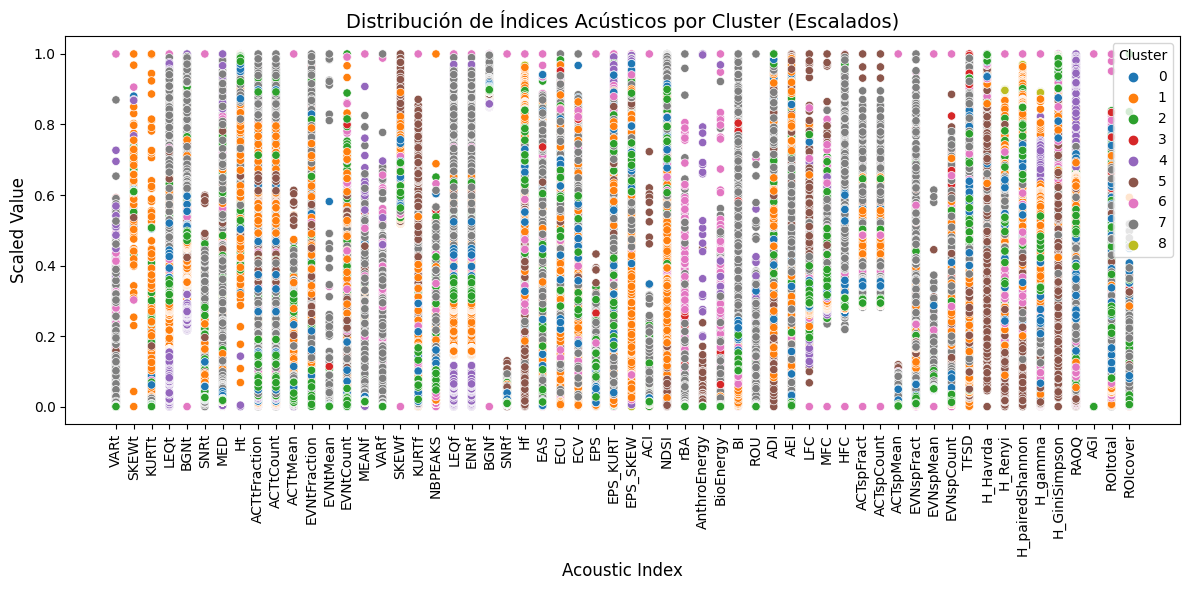

In [19]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


if df_new.index.equals(df_ai.index):
    # Si los índices coinciden, añadimos la columna directamente
    print("They are equals")
    df_ai['cluster'] = df_new['cluster']
    
else:
    raise exception("Check dataframes")

# Seleccionar las columnas con los índices acústicos
indices_acusticos = df_ai.columns[2:-7]

# Crear un escalador MinMax
scaler = MinMaxScaler()

# Escalar los valores de los índices acústicos
df_ai[indices_acusticos] = scaler.fit_transform(df_ai[indices_acusticos])

# Convertir el DataFrame a formato largo para la visualización
df_plot = df_ai.melt(id_vars='cluster', value_vars=indices_acusticos, 
                     var_name='Índice Acústico', value_name='Valor')

# Crear el scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_plot, x='Índice Acústico', y='Valor', hue='cluster', palette='tab10')

# Configurar título y etiquetas
plt.title('Distribución de Índices Acústicos por Cluster (Escalados)', fontsize=14)
plt.xlabel('Acoustic Index', fontsize=12)
plt.ylabel('Scaled Value', fontsize=12)
plt.xticks(rotation=90)
plt.legend(title='Cluster')
plt.tight_layout()

# Mostrar la gráfica
plt.show()

/tmp/ipykernel_9853/1364245975.py:35: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


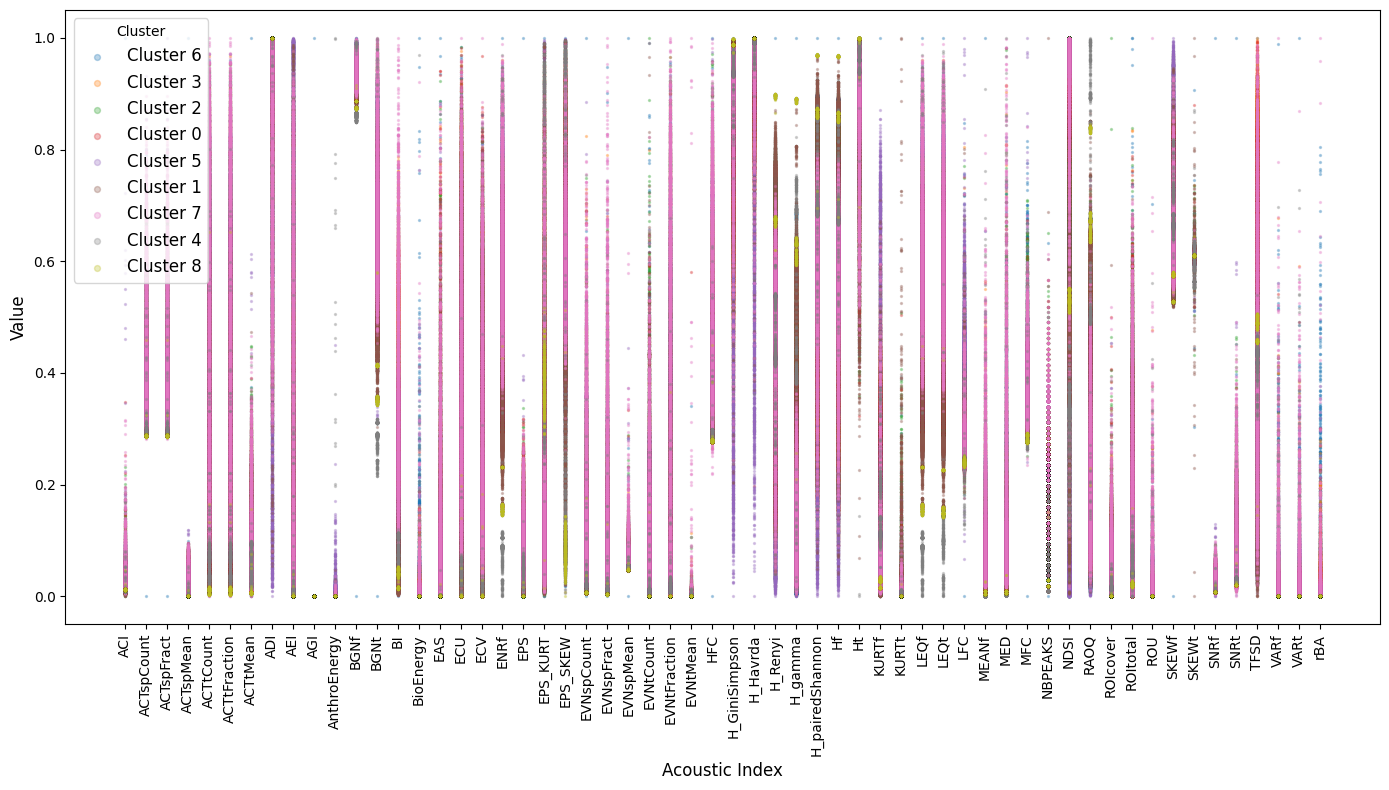

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convertir el DataFrame a formato largo
indices_acusticos = df_ai.columns[2:-7]
df_plot = df_ai.melt(id_vars='cluster', value_vars=indices_acusticos, 
                     var_name='Índice Acústico', value_name='Valor')

# Asignar valores únicos de X para cada índice
df_plot['X'] = df_plot['Índice Acústico'].astype('category').cat.codes

# Crear la paleta de colores tab10
palette = sns.color_palette("Set1", 5)  # Paleta con 20 colores bien diferenciados


# Crear el scatter plot con diferentes colores por cluster
plt.figure(figsize=(14, 8))

for i, cluster in enumerate(df_plot['cluster'].unique()):
    subset = df_plot[df_plot['cluster'] == cluster]
    plt.scatter(
        subset['X'], subset['Valor'], 
        label=f'Cluster {cluster}', 
        alpha=0.3, s=2
    )

# Configurar el eje X con etiquetas de los índices
plt.xticks(ticks=df_plot['X'].unique(), labels=indices_acusticos, rotation=90)

# Configurar título y etiquetas
plt.xlabel('Acoustic Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(title='Cluster', fontsize=12, markerscale=3)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

\section*{Gráfico de Barras de Varianza Total}

El gráfico muestra la \textbf{varianza total} de cada índice acústico calculada entre diferentes clusters. La varianza total para cada índice acústico $i$ se obtiene sumando la varianza dentro de cada cluster $c$, como se define en la ecuación:

\begin{equation}
\text{Varianza Total}_i = \sum_{c=1}^C \text{Var}_c(X_i),
\end{equation}

donde:
\begin{itemize}
    \item $\text{Var}_c(X_i)$ es la varianza del índice acústico $i$ dentro del cluster $c$.
    \item $C$ es el número total de clusters.
    \item $X_i$ representa los valores del índice acústico $i$.
\end{itemize}

La gráfica de barras ordena los índices acústicos de mayor a menor varianza total, permitiendo identificar los índices con mayor variabilidad entre clusters. Los índices con mayor varianza son los que probablemente expliquen mejor las diferencias entre clusters.


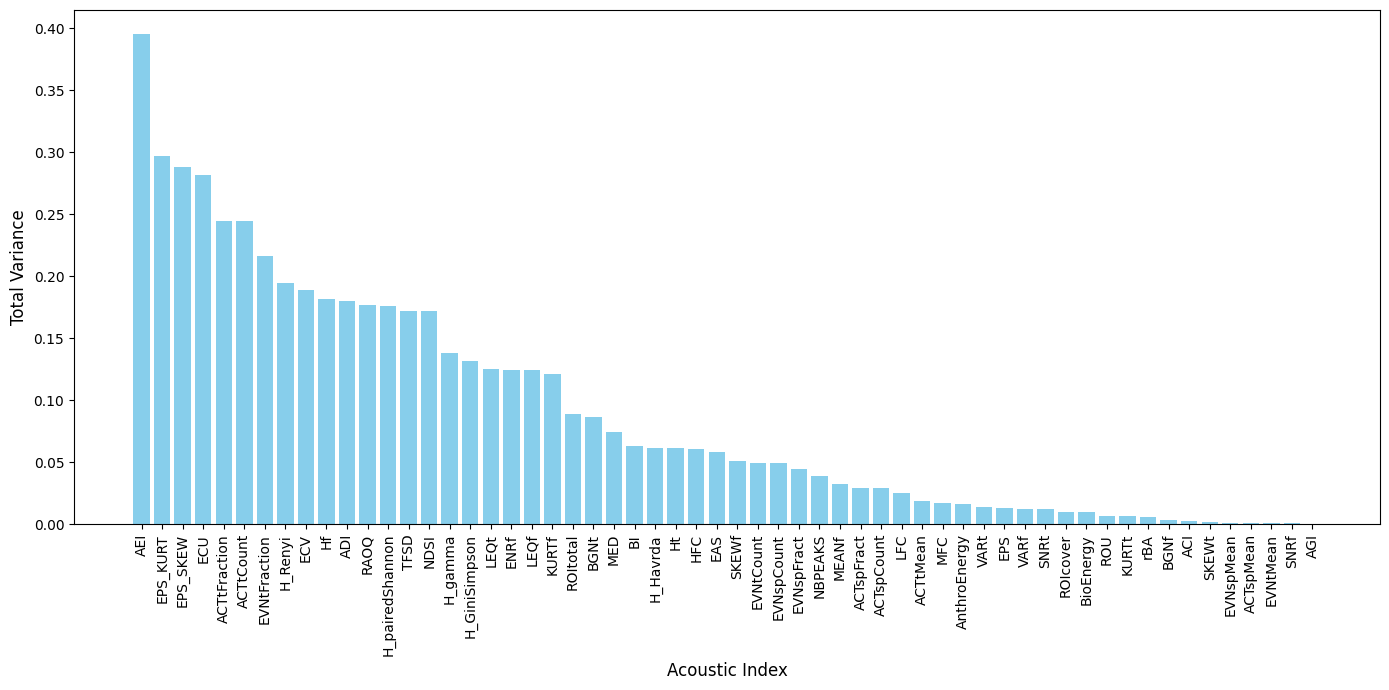

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
# Calcular la varianza total de cada índice acústico a través de todos los clusters
cluster_varianza = df_ai.groupby('cluster')[indices_acusticos].var()  # Varianza por cluster
varianza_total = cluster_varianza.sum()  # Sumar varianza de cada índice en todos los clusters

# Ordenar la varianza de mayor a menor
varianza_total = varianza_total.sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))
plt.bar(varianza_total.index, varianza_total.values, color='skyblue')

# Configurar título y etiquetas
plt.title('', fontsize=14)
plt.xlabel('Acoustic Index', fontsize=12)
plt.ylabel('Total Variance', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

Índices seleccionados: Index(['AEI', 'EPS_KURT', 'EPS_SKEW', 'ECU', 'ACTtFraction', 'ACTtCount',
       'EVNtFraction', 'H_Renyi', 'ECV', 'Hf'],
      dtype='object')


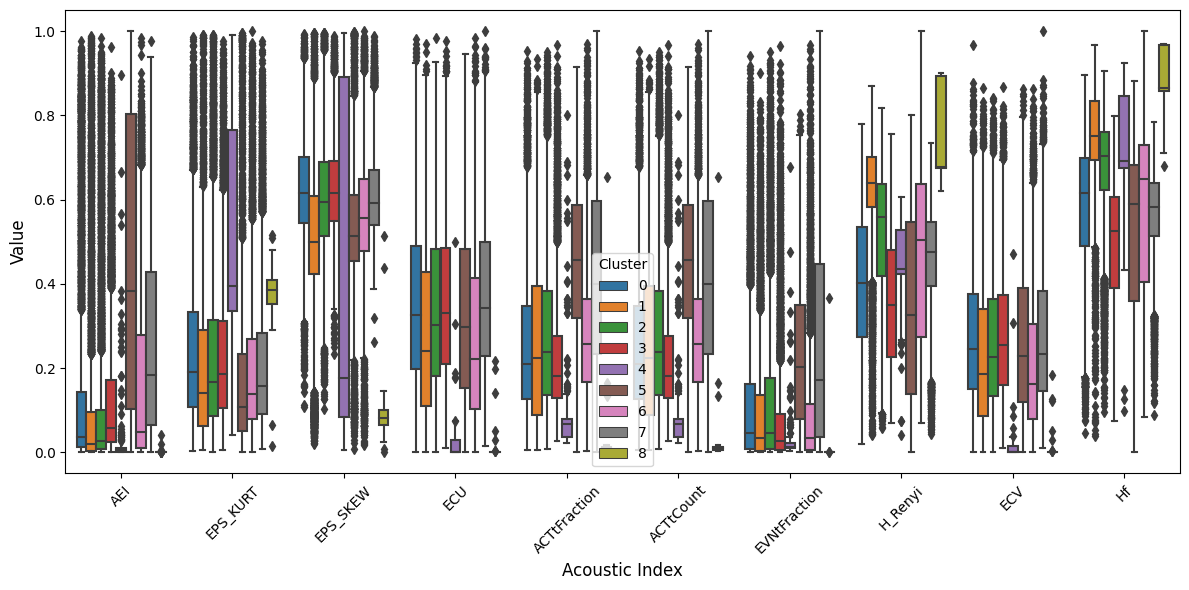

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la varianza por cluster para cada índice acústico
indices_acusticos = df_ai.columns[2:-7]  # Seleccionar columnas de índices acústicos
cluster_varianza = df_ai.groupby('cluster')[indices_acusticos].var()  # Varianza por cluster
varianza_total = cluster_varianza.sum()  # Sumar varianza a través de clusters

# Seleccionar los 10 índices con mayor varianza
top_10_indices = varianza_total.nlargest(10).index
print("Índices seleccionados:", top_10_indices)

# Filtrar el DataFrame para incluir solo los índices seleccionados
df_plot = df_ai.melt(id_vars='cluster', value_vars=top_10_indices, 
                     var_name='Índice Acústico', value_name='Valor')

# Crear el boxplot para los 10 índices seleccionados
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_plot, x='Índice Acústico', y='Valor', hue='cluster', palette='tab10')

# Configurar título y etiquetas
plt.title('', fontsize=14)
plt.xlabel('Acoustic Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()

# Mostrar la gráfica
plt.show()

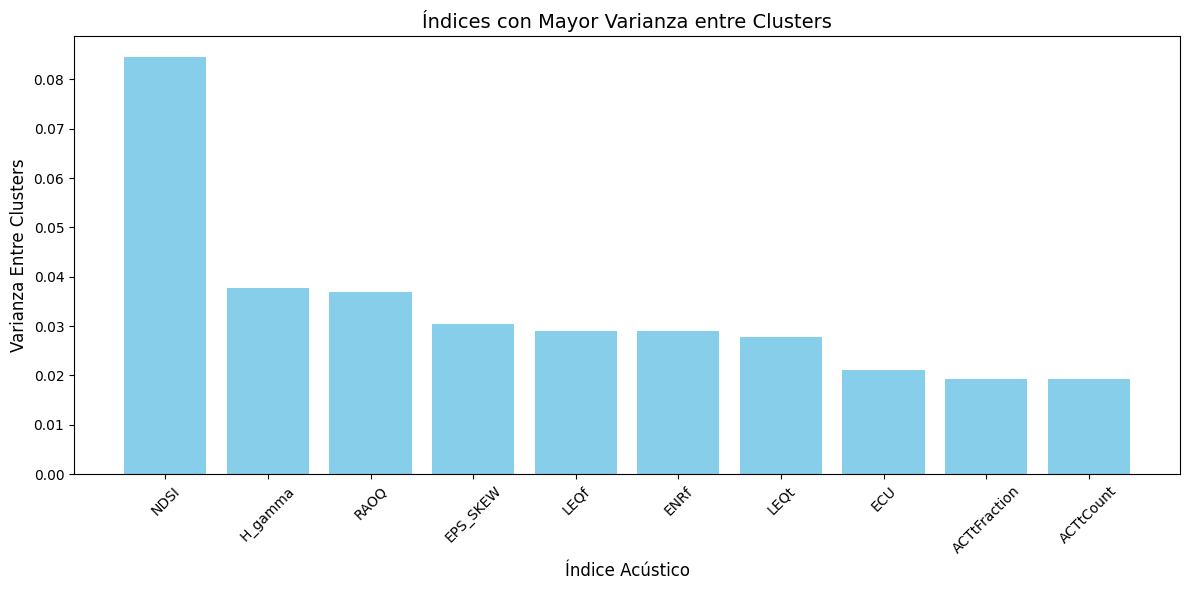

Top 10 índices con mayor varianza entre clusters:
NDSI            0.084508
H_gamma         0.037667
RAOQ            0.036904
EPS_SKEW        0.030348
LEQf            0.028941
ENRf            0.028941
LEQt            0.027761
ECU             0.021138
ACTtFraction    0.019336
ACTtCount       0.019336
dtype: float64


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Seleccionar los índices acústicos
indices_acusticos = df_ai.columns[2:-7]  # Asumimos que estas son las columnas de índices

# Calcular las medias de cada índice en cada cluster
cluster_means = df_ai.groupby('cluster')[indices_acusticos].mean()

# Calcular la varianza de las medias entre clusters
varianza_entre_clusters = cluster_means.var()

# Ordenar por mayor varianza
varianza_entre_clusters = varianza_entre_clusters.sort_values(ascending=False)

# Seleccionar los 10 índices con mayor varianza entre clusters
top_10_varianza = varianza_entre_clusters.head(10)

# Crear un gráfico de barras para los 10 índices con mayor varianza
plt.figure(figsize=(12, 6))
plt.bar(top_10_varianza.index, top_10_varianza.values, color='skyblue')
plt.title('Índices con Mayor Varianza entre Clusters', fontsize=14)
plt.xlabel('Índice Acústico', fontsize=12)
plt.ylabel('Varianza Entre Clusters', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

# Mostrar los índices seleccionados
print("Top 10 índices con mayor varianza entre clusters:")
print(top_10_varianza)

Top 10 índices acústicos con mayor varianza entre clusters:
Index(['NDSI', 'H_gamma', 'RAOQ', 'EPS_SKEW', 'LEQf', 'ENRf', 'LEQt', 'ECU',
       'ACTtFraction', 'ACTtCount'],
      dtype='object')


/tmp/ipykernel_9853/3257411541.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


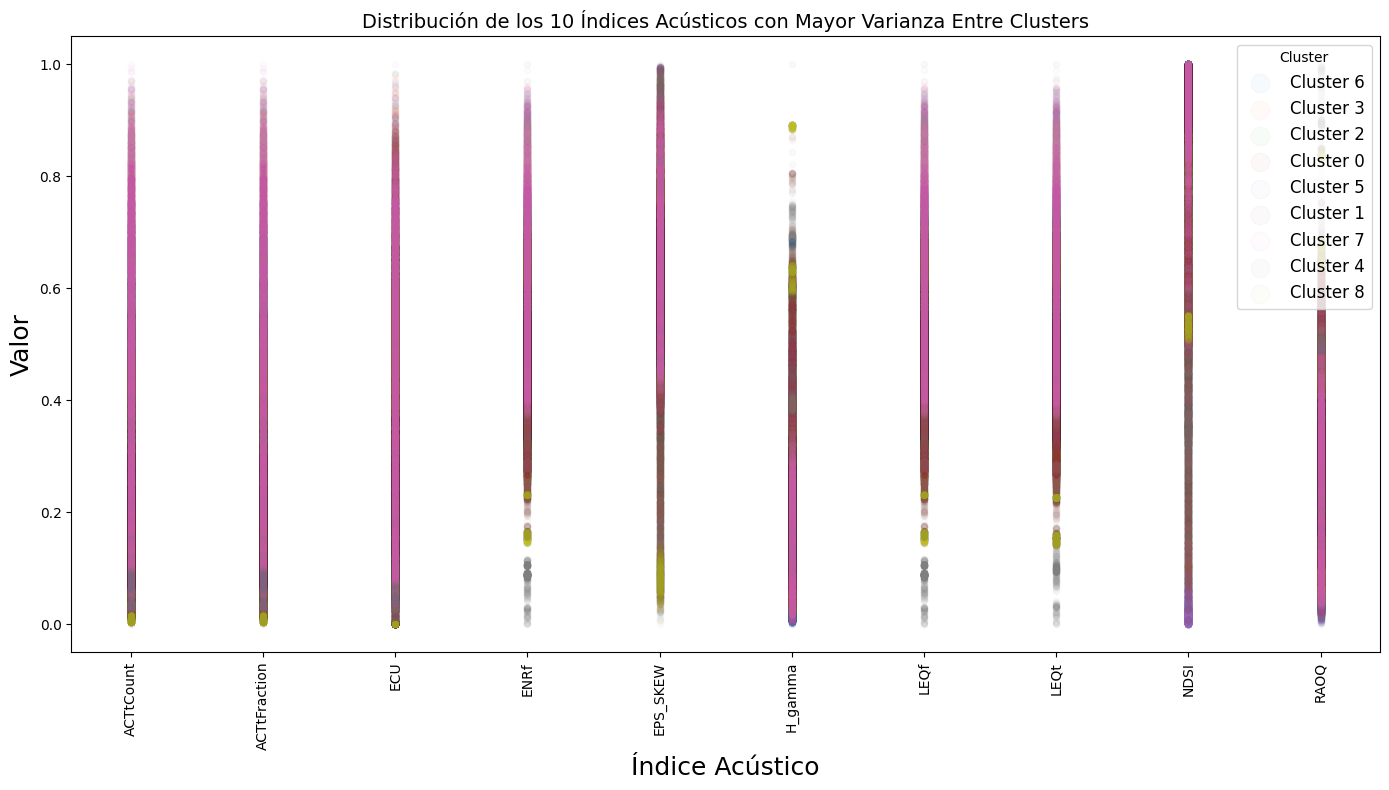

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

indices_acusticos = df_ai.columns[2:-7]  # Seleccionar columnas de índices acústicos
cluster_means = df_ai.groupby('cluster')[indices_acusticos].mean()  # Medias por cluster
varianza_entre_clusters = cluster_means.var()  # Varianza entre clusters

top_10_indices = varianza_entre_clusters.nlargest(10).index
print("Top 10 índices acústicos con mayor varianza entre clusters:")
print(top_10_indices)

df_plot = df_ai.melt(id_vars='cluster', value_vars=top_10_indices, 
                     var_name='Índice Acústico', value_name='Valor')

df_plot['X'] = df_plot['Índice Acústico'].astype('category').cat.codes

plt.figure(figsize=(14, 8))

for cluster in df_plot['cluster'].unique():
    subset = df_plot[df_plot['cluster'] == cluster]
    plt.scatter(subset['X'], subset['Valor'], label=f'Cluster {cluster}', alpha=0.03, s=20)

plt.xticks(ticks=df_plot['X'].unique(), labels=top_10_indices, rotation=90)

plt.title('Distribución de los 10 Índices Acústicos con Mayor Varianza Entre Clusters', fontsize=14)
plt.xlabel('Índice Acústico', fontsize=18)
plt.ylabel('Valor', fontsize=18)
plt.legend(title='Cluster', fontsize=12, markerscale=3)
plt.tight_layout()

plt.show()

Top 10 índices acústicos con mayor varianza entre clusters:
Index(['NDSI', 'H_gamma', 'RAOQ', 'EPS_SKEW', 'LEQf', 'ENRf', 'LEQt', 'ECU',
       'ACTtFraction', 'ACTtCount'],
      dtype='object')


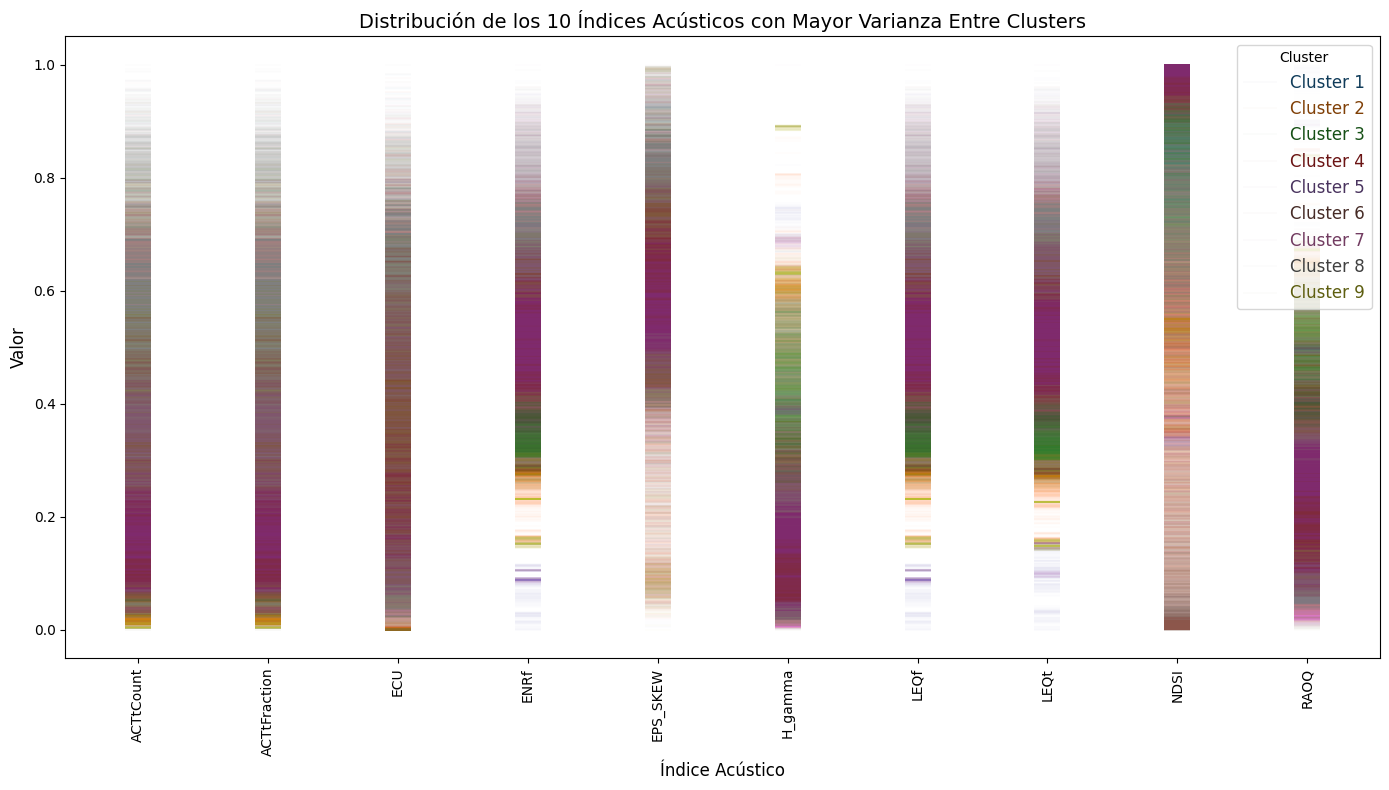

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgb

# Función para oscurecer colores
def darken_color(color, amount=0.5):
    """
    Oscurece un color dado mezclándolo con negro.
    - `color`: El color original en formato hex o RGB.
    - `amount`: Qué tan oscuro (0 = negro, 1 = color original).
    """
    return tuple(amount * c for c in to_rgb(color))

# Seleccionar columnas de índices acústicos
indices_acusticos = df_ai.columns[2:-7]  
cluster_means = df_ai.groupby('cluster')[indices_acusticos].mean()  # Medias por cluster
varianza_entre_clusters = cluster_means.var()  # Varianza entre clusters

# Obtener los 10 índices acústicos con mayor varianza
top_10_indices = varianza_entre_clusters.nlargest(10).index
print("Top 10 índices acústicos con mayor varianza entre clusters:")
print(top_10_indices)

# Preparar el DataFrame para la gráfica
df_plot = df_ai.melt(id_vars='cluster', value_vars=top_10_indices, 
                     var_name='Índice Acústico', value_name='Valor')

# Asignar valores únicos a cada índice acústico
df_plot['X'] = df_plot['Índice Acústico'].astype('category').cat.codes

# Crear colores para los clusters
unique_clusters = sorted(df_plot['cluster'].unique())  # Ordenar clusters
colors = sns.color_palette("tab10", len(unique_clusters))  # Paleta base
dark_colors = [darken_color(c, amount=0.5) for c in colors]  # Oscurecer para la leyenda

# Crear la figura
plt.figure(figsize=(14, 8))

# Dibujar líneas horizontales para cada cluster
for i, cluster in enumerate(unique_clusters):
    subset = df_plot[df_plot['cluster'] == cluster]
    plt.hlines(
        y=subset['Valor'], xmin=subset['X'] - 0.1, xmax=subset['X'] + 0.1,
        color=colors[i], label=f'Cluster {cluster+1}', alpha=0.8, linewidth=0.02
    )

# Configurar el eje X con etiquetas de los índices acústicos
plt.xticks(ticks=df_plot['X'].unique(), labels=top_10_indices, rotation=90)

# Crear la leyenda con colores oscuros y clusters ordenados
legend = plt.legend(title='Cluster', fontsize=12, markerscale=5)

# Oscurecer tanto las líneas como el texto en la leyenda
for i, text in enumerate(legend.get_texts()):
    text.set_color(dark_colors[i])  # Oscurecer texto
for i, handle in enumerate(legend.legendHandles):
    handle.set_color(dark_colors[i])  # Oscurecer líneas
    handle.set_alpha(1.0)            # Asegurarse de que no sean transparentes

# Títulos y etiquetas
plt.title('Distribución de los 10 Índices Acústicos con Mayor Varianza Entre Clusters', fontsize=14)
plt.xlabel('Índice Acústico', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.tight_layout()

# Mostrar la gráfica
plt.show()



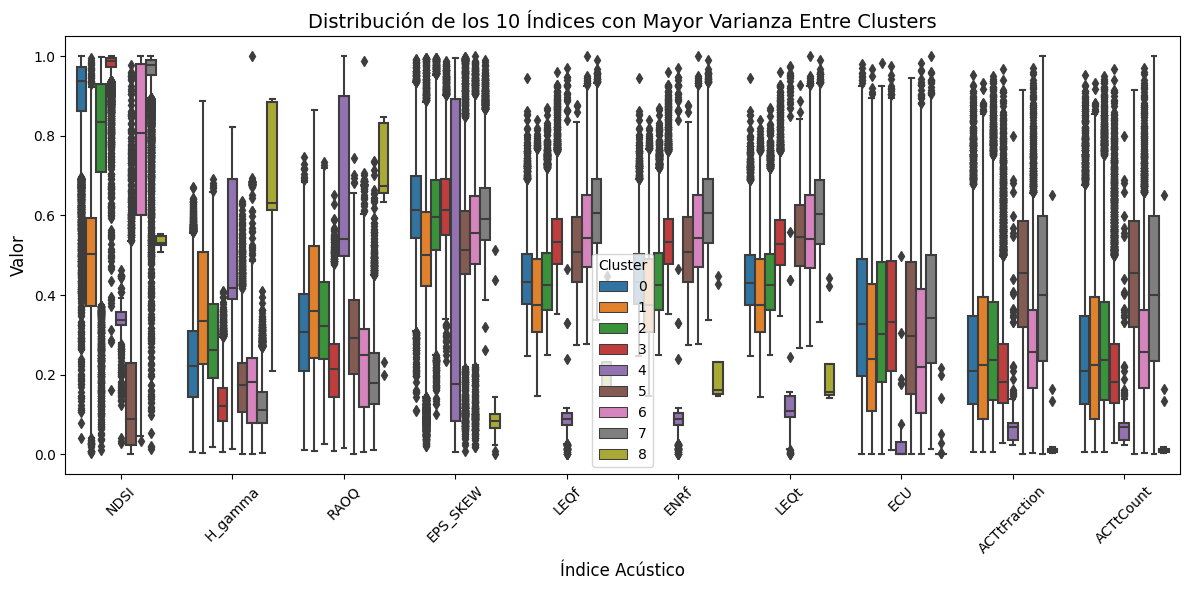

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# # Calcular la varianza entre clusters
# indices_acusticos = df_ai.columns[2:-7]  # Seleccionar columnas de índices acústicos
# cluster_means = df_ai.groupby('cluster')[indices_acusticos].mean()  # Medias por cluster
# varianza_entre_clusters = cluster_means.var()  # Varianza entre clusters

# # Seleccionar los 10 índices con mayor varianza entre clusters
# top_10_indices = varianza_entre_clusters.nlargest(10).index
# print("Top 10 índices acústicos con mayor varianza entre clusters:", top_10_indices)

# Filtrar el DataFrame para incluir solo los índices seleccionados
df_plot = df_ai.melt(id_vars='cluster', value_vars=top_10_indices, 
                     var_name='Índice Acústico', value_name='Valor')

# Crear el boxplot para los 10 índices seleccionados
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_plot, x='Índice Acústico', y='Valor', hue='cluster', palette='tab10')

# Configurar título y etiquetas
plt.title('Distribución de los 10 Índices con Mayor Varianza Entre Clusters', fontsize=14)
plt.xlabel('Índice Acústico', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# GLMs

In [27]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

X= GLM[[f"Cluster {i}" for i in range(len(GLM.columns)-6)]]
X = X.to_numpy()
y = GLM["Mean"]

NameError: name 'GLM' is not defined